# **Hypothesis Testing**

Joseph Lardie

September 2023

# **Imports**

In [1]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt
import plotly

# Scipy
from scipy import stats
from scipy.stats import norm, pearsonr
import statsmodels.api as sm

# Warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading in datasets**

In [2]:
# Loading NYC Restaraunt Inspection Data
rdf = pd.read_csv('rdf')

In [3]:
# Loading NYC Restaraunt Yelp Review Data
ydf = pd.read_csv('ydf')

In [4]:
# Restaurant Inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210611 entries, 0 to 210610
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  210611 non-null  int64  
 1   DBA                    209970 non-null  object 
 2   BORO                   210611 non-null  object 
 3   BUILDING               210308 non-null  object 
 4   STREET                 210607 non-null  object 
 5   ZIPCODE                207890 non-null  float64
 6   CUISINE DESCRIPTION    208186 non-null  object 
 7   INSPECTION DATE        210611 non-null  object 
 8   ACTION                 208186 non-null  object 
 9   VIOLATION CODE         207055 non-null  object 
 10  VIOLATION DESCRIPTION  207055 non-null  object 
 11  CRITICAL FLAG          210611 non-null  object 
 12  SCORE                  200542 non-null  float64
 13  GRADE                  103135 non-null  object 
 14  GRADE DATE             94324 non-nul

In [5]:
# Yelp data
ydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alias         847 non-null    object 
 1   name          847 non-null    object 
 2   image_url     847 non-null    object 
 3   url           847 non-null    object 
 4   review_count  847 non-null    int64  
 5   categories    847 non-null    object 
 6   rating        847 non-null    float64
 7   coordinates   847 non-null    object 
 8   transactions  847 non-null    object 
 9   location      847 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 66.3+ KB


## **Selecting Subset of Pizza Restaurants in Brooklyn**

In [6]:
# Selecting subset of only restaurants from Brooklyn
brooklyndf = rdf[rdf['BORO'].str.lower() == 'brooklyn']

In [7]:
# Selecting subset of only restaurants in Brooklyn that have pizza in the cuisine description
pizza_brooklyn_subset = brooklyndf[(brooklyndf['CUISINE DESCRIPTION'].str.lower() == 'pizza')]

In [8]:
# Filtering out rows with NaN in the 'GRADE' column
pizza_brooklyn_subset = pizza_brooklyn_subset.dropna(subset=['GRADE'])

In [9]:
# Taking a look at Brooklyn pizza restaurants in inspection data
print(pizza_brooklyn_subset)

           CAMIS                                  DBA      BORO BUILDING  \
115     50011046               LA BELLA PIZZA EXPRESS  Brooklyn     2178   
722     50095131                             DOMINO'S  Brooklyn     2196   
829     41459621  GINO'S BRICK OVEN PIZZA & TRATTORIA  Brooklyn   548550   
981     50067979                       TONY PEPPERONI  Brooklyn     7502   
1087    50134916                           ROMA PIZZA  Brooklyn     1101   
...          ...                                  ...       ...      ...   
210290  41393052                            IGNAZIO'S  Brooklyn        4   
210311  50105343                       PROSPECT PIZZA  Brooklyn      599   
210325  50062985           SHIPWRECKED MINIATURE GOLF  Brooklyn      619   
210459  50089510                         ROSA'S PIZZA  Brooklyn      374   
210585  50001675       GINO'S CUCINA BRICK OVEN PIZZA  Brooklyn      723   

                     STREET  ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
115        

## **Merging Yelp data with Inspections Data**

In [10]:
# Making the names of the restaurants in both data sets compatable for the merge
column_name = 'name'
# Matching up the names for both datasets
ydf['name'] = ydf['name'].apply(lambda x: str(x).upper())

In [11]:
# Merging the two data sets on the names of the restaurants 
merged_df = pd.merge(pizza_brooklyn_subset, ydf, left_on='DBA', right_on='name', how='inner', indicator=True)

# Dropping any Duplicate rows
merged_df.drop_duplicates(inplace=True)

# Displaying the merged dataframe
print("\nMerged DataFrame:")
print(merged_df)


Merged DataFrame:
        CAMIS                                  DBA      BORO BUILDING  \
0    41459621  GINO'S BRICK OVEN PIZZA & TRATTORIA  Brooklyn   548550   
1    41459621  GINO'S BRICK OVEN PIZZA & TRATTORIA  Brooklyn   548550   
2    41459621  GINO'S BRICK OVEN PIZZA & TRATTORIA  Brooklyn   548550   
3    41459621  GINO'S BRICK OVEN PIZZA & TRATTORIA  Brooklyn   548550   
4    50134916                           ROMA PIZZA  Brooklyn     1101   
..        ...                                  ...       ...      ...   
512  41393052                            IGNAZIO'S  Brooklyn        4   
513  41393052                            IGNAZIO'S  Brooklyn        4   
514  41393052                            IGNAZIO'S  Brooklyn        4   
515  41393052                            IGNAZIO'S  Brooklyn        4   
516  50000967                              WHEATED  Brooklyn      905   

              STREET  ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
0    FLATBUSH AVENUE      NaN      

In [12]:
# looking at the data
merged_df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,...,name,image_url,url,review_count,categories,rating,coordinates,transactions,location,_merge
0,41459621,GINO'S BRICK OVEN PIZZA & TRATTORIA,Brooklyn,548550,FLATBUSH AVENUE,NaN,Pizza,10/13/2022,Violations were cited in the following area(s).,02B,...,GINO'S BRICK OVEN PIZZA & TRATTORIA,https://s3-media1.fl.yelpcdn.com/bphoto/ovQ-Ps...,https://www.yelp.com/biz/ginos-brick-oven-pizz...,277,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.0,"{'latitude': 40.6605221493743, 'longitude': -7...","['delivery', 'pickup']","{'address1': '548 Flatbush Ave', 'address2': '...",both
1,41459621,GINO'S BRICK OVEN PIZZA & TRATTORIA,Brooklyn,548550,FLATBUSH AVENUE,NaN,Pizza,09/03/2021,Violations were cited in the following area(s).,08C,...,GINO'S BRICK OVEN PIZZA & TRATTORIA,https://s3-media1.fl.yelpcdn.com/bphoto/ovQ-Ps...,https://www.yelp.com/biz/ginos-brick-oven-pizz...,277,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.0,"{'latitude': 40.6605221493743, 'longitude': -7...","['delivery', 'pickup']","{'address1': '548 Flatbush Ave', 'address2': '...",both
2,41459621,GINO'S BRICK OVEN PIZZA & TRATTORIA,Brooklyn,548550,FLATBUSH AVENUE,NaN,Pizza,09/03/2021,Violations were cited in the following area(s).,10F,...,GINO'S BRICK OVEN PIZZA & TRATTORIA,https://s3-media1.fl.yelpcdn.com/bphoto/ovQ-Ps...,https://www.yelp.com/biz/ginos-brick-oven-pizz...,277,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.0,"{'latitude': 40.6605221493743, 'longitude': -7...","['delivery', 'pickup']","{'address1': '548 Flatbush Ave', 'address2': '...",both
3,41459621,GINO'S BRICK OVEN PIZZA & TRATTORIA,Brooklyn,548550,FLATBUSH AVENUE,NaN,Pizza,09/03/2021,Violations were cited in the following area(s).,02B,...,GINO'S BRICK OVEN PIZZA & TRATTORIA,https://s3-media1.fl.yelpcdn.com/bphoto/ovQ-Ps...,https://www.yelp.com/biz/ginos-brick-oven-pizz...,277,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.0,"{'latitude': 40.6605221493743, 'longitude': -7...","['delivery', 'pickup']","{'address1': '548 Flatbush Ave', 'address2': '...",both
4,50134916,ROMA PIZZA,Brooklyn,1101,AVENUE U,11223.0,Pizza,07/19/2023,Violations were cited in the following area(s).,02B,...,ROMA PIZZA,https://s3-media1.fl.yelpcdn.com/bphoto/OQeT14...,https://www.yelp.com/biz/roma-pizza-new-york-4...,390,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",3.5,"{'latitude': 40.77843, 'longitude': -73.94863}","['pickup', 'delivery']","{'address1': '1701 1st Ave', 'address2': '', '...",both


In [13]:
# Looking at the merged dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 0 to 516
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CAMIS                  503 non-null    int64   
 1   DBA                    503 non-null    object  
 2   BORO                   503 non-null    object  
 3   BUILDING               503 non-null    object  
 4   STREET                 503 non-null    object  
 5   ZIPCODE                499 non-null    float64 
 6   CUISINE DESCRIPTION    503 non-null    object  
 7   INSPECTION DATE        503 non-null    object  
 8   ACTION                 503 non-null    object  
 9   VIOLATION CODE         501 non-null    object  
 10  VIOLATION DESCRIPTION  501 non-null    object  
 11  CRITICAL FLAG          503 non-null    object  
 12  SCORE                  503 non-null    float64 
 13  GRADE                  503 non-null    object  
 14  GRADE DATE             496 non-null    obj

In [14]:
# Use boolean indexing to filter rows where the 'name_column' matches the target name
specific_restaurant = merged_df[merged_df['name'] == 'FRONT STREET PIZZA']

# Print or further process the specific restaurant data
print(specific_restaurant)

        CAMIS                 DBA      BORO BUILDING        STREET  ZIPCODE  \
206  50124791  FRONT STREET PIZZA  Brooklyn       80  FRONT STREET  11201.0   
207  50124791  FRONT STREET PIZZA  Brooklyn       80  FRONT STREET  11201.0   
208  50124791  FRONT STREET PIZZA  Brooklyn       80  FRONT STREET  11201.0   
209  50124791  FRONT STREET PIZZA  Brooklyn       80  FRONT STREET  11201.0   

    CUISINE DESCRIPTION INSPECTION DATE  \
206               Pizza      03/20/2023   
207               Pizza      03/20/2023   
208               Pizza      03/20/2023   
209               Pizza      03/20/2023   

                                              ACTION VIOLATION CODE  ...  \
206  Violations were cited in the following area(s).            10F  ...   
207  Violations were cited in the following area(s).            02B  ...   
208  Violations were cited in the following area(s).            02H  ...   
209  Violations were cited in the following area(s).            09C  ...   

       

# **Data Cleaning**

In [15]:
# Creating a new column 'unique_id' by combining 'name' and 'CAMIS'
merged_df['unique_id'] = merged_df['name'] + '_' + merged_df['CAMIS'].astype(str)

# Sorting the DataFrame based on the new 'unique_id' column
merged_df = merged_df.sort_values(by='unique_id')

# If you want to keep only the last occurrence of each unique identifier, you can use the following:
merged_df = merged_df.sort_values(by='INSPECTION DATE').drop_duplicates(subset=['unique_id'], keep='last')

In [16]:
# Dropping irrelevant columns
merged_df.drop(['_merge', 'GRADE', 'BUILDING', 'ZIPCODE', 'Council District', 'Longitude', 'Latitude', 'coordinates', 'url','CRITICAL FLAG', 'alias', 'categories'], axis=1, inplace=True)

In [17]:
# checking missing data in data 
def check_missing_data(rdf):
    total = merged_df.isnull().sum().sort_values(ascending = False)
    percent = (merged_df.isnull().sum()/merged_df.isnull().count()*100).sort_values(ascending = False)
    percent = percent.round(2).astype(str) + '%'
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_result = check_missing_data(merged_df)
missing_data_result.head()

,Total,Percent
GRADE DATE,2,2.44%
CAMIS,0,0.0%
location,0,0.0%
transactions,0,0.0%
rating,0,0.0%


In [18]:
# Function to eliminate rows with missing Grade dates
def eliminate_missing_grade_date_rows(merged_df):
    """
    Eliminate rows with missing data in the "GRADE DATE" column.

    Returns:
    - Cleaned DataFrame without rows with missing "GRADE DATE"
    """
    # Drop rows with missing values in the "GRADE DATE" column
    cleaned_dataframe = merged_df.dropna(subset=["GRADE DATE"])

    return cleaned_dataframe

merged_df = eliminate_missing_grade_date_rows(merged_df)

In [19]:
# looking at the types of Inspections
merged_df['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection              36
Cycle Inspection / Re-inspection                   25
Pre-permit (Operational) / Initial Inspection      12
Pre-permit (Operational) / Re-inspection            3
Cycle Inspection / Reopening Inspection             3
Pre-permit (Operational) / Reopening Inspection     1
Name: INSPECTION TYPE, dtype: int64

In [20]:
# Filtering out only the initial inspections and re-inspections
def filter_inspection_type(merged_df):
    """
    Filter rows based on the values in the "INSPECTION TYPE" column.

    Returns:
    - DataFrame containing only rows with specified inspection types
    """
    inspection_types_to_keep = ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection']
    filtered_rdf = merged_df.loc[merged_df['INSPECTION TYPE'].isin(inspection_types_to_keep)]

    return filtered_rdf

merged_df = filter_inspection_type(merged_df)

In [21]:
#create a dataframe with the most recent inspection data
merged_df = merged_df.sort_values(by='INSPECTION DATE').drop_duplicates(subset=['CAMIS'], keep='last')

In [22]:
# Viewing the cleaaned dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 266 to 437
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  61 non-null     int64  
 1   DBA                    61 non-null     object 
 2   BORO                   61 non-null     object 
 3   STREET                 61 non-null     object 
 4   CUISINE DESCRIPTION    61 non-null     object 
 5   INSPECTION DATE        61 non-null     object 
 6   ACTION                 61 non-null     object 
 7   VIOLATION CODE         61 non-null     object 
 8   VIOLATION DESCRIPTION  61 non-null     object 
 9   SCORE                  61 non-null     float64
 10  GRADE DATE             61 non-null     object 
 11  INSPECTION TYPE        61 non-null     object 
 12  name                   61 non-null     object 
 13  image_url              61 non-null     object 
 14  review_count           61 non-null     int64  
 15  ratin

In [23]:
merged_df.describe()

,CAMIS,SCORE,review_count,rating
count,6.100000e+01,61.000000,61.000000,61.000000
mean,4.579030e+07,12.540984,325.786885,3.713115
std,4.535248e+06,9.078498,521.671516,0.535872
min,4.038630e+07,2.000000,22.000000,1.500000
25%,4.127338e+07,8.000000,86.000000,3.500000
50%,5.000100e+07,12.000000,202.000000,3.500000
75%,5.007050e+07,13.000000,291.000000,4.000000
max,5.012784e+07,64.000000,3322.000000,4.500000


In [24]:
#count number of unique names
len(merged_df['name'].unique())

50

In [25]:
#count number of unique names
len(merged_df['CAMIS'].unique())

61

In [26]:
merged_df['unique_id'].value_counts()

JOE'S PIZZA_50084972                  1
FAZIO'S_50056980                      1
MIKE'S PIZZA_40745618                 1
ARTICHOKE BASILLE'S PIZZA_50057010    1
COZZI PIZZA_41404362                  1
                                     ..
LENNY'S PIZZA_40553657                1
MY LITTLE PIZZERIA_40593848           1
ENOTECA ON COURT_41296556             1
KRISPY PIZZA_40592791                 1
ROBERTA'S_41307383                    1
Name: unique_id, Length: 61, dtype: int64

# **Hypothesis Testing**

## **Hypothesis Test 1:Try to find a correlation between scores on inspections and the review count on YELP**

- The null hypothesis for this question would be that the restaurant inspection score does not significantly affect the number of reviews on Yelp for pizza restaurants in Brooklyn NY

- The alternative hypothesis for this question would be that the restaurant inspection score does significantly affect the number of reviews on Yelp for the pizza restaurants in Brooklyn NY.

In [27]:
# Performing Pearsonr correlation test
correlation, p_value = pearsonr(merged_df['review_count'], merged_df['SCORE'])

# Print results
print(f'Correlation: {correlation:.2f}')
print(f'P-value: {p_value:.4f}')

# Check for significance based on the p-value
if p_value < 0.05:
    print('The correlation is statistically significant.')
else:
    print('There is no significant correlation.')

Correlation: 0.16
P-value: 0.2120
There is no significant correlation.


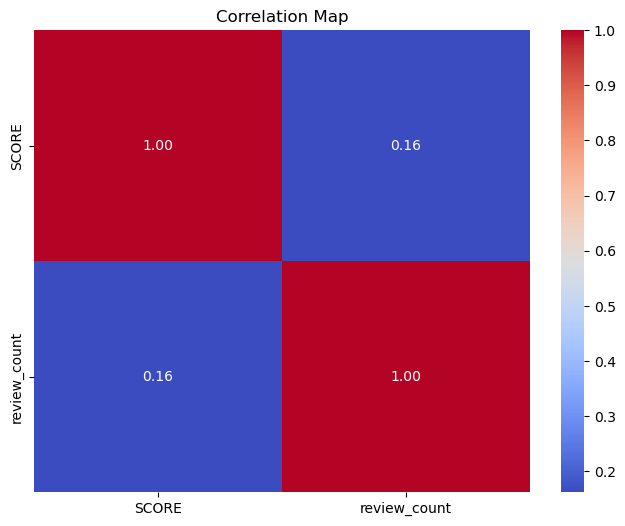

In [28]:
numeric_columns = ['SCORE', 'review_count']

mdf_numeric = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce').dropna()

c_matrix = mdf_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Map')
plt.show()

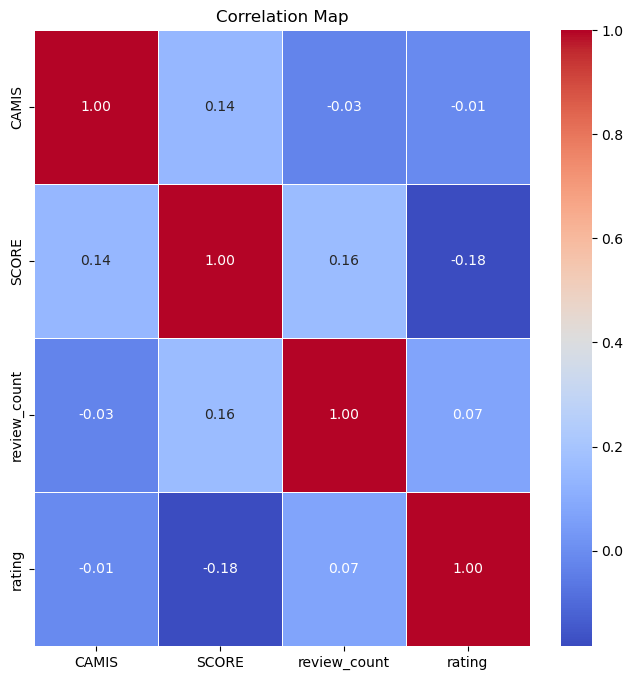

In [29]:
# Compute the correlation matrix
correlation_matrix = merged_df.corr()

# Plot the correlation heatmap using seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Map')
plt.show()

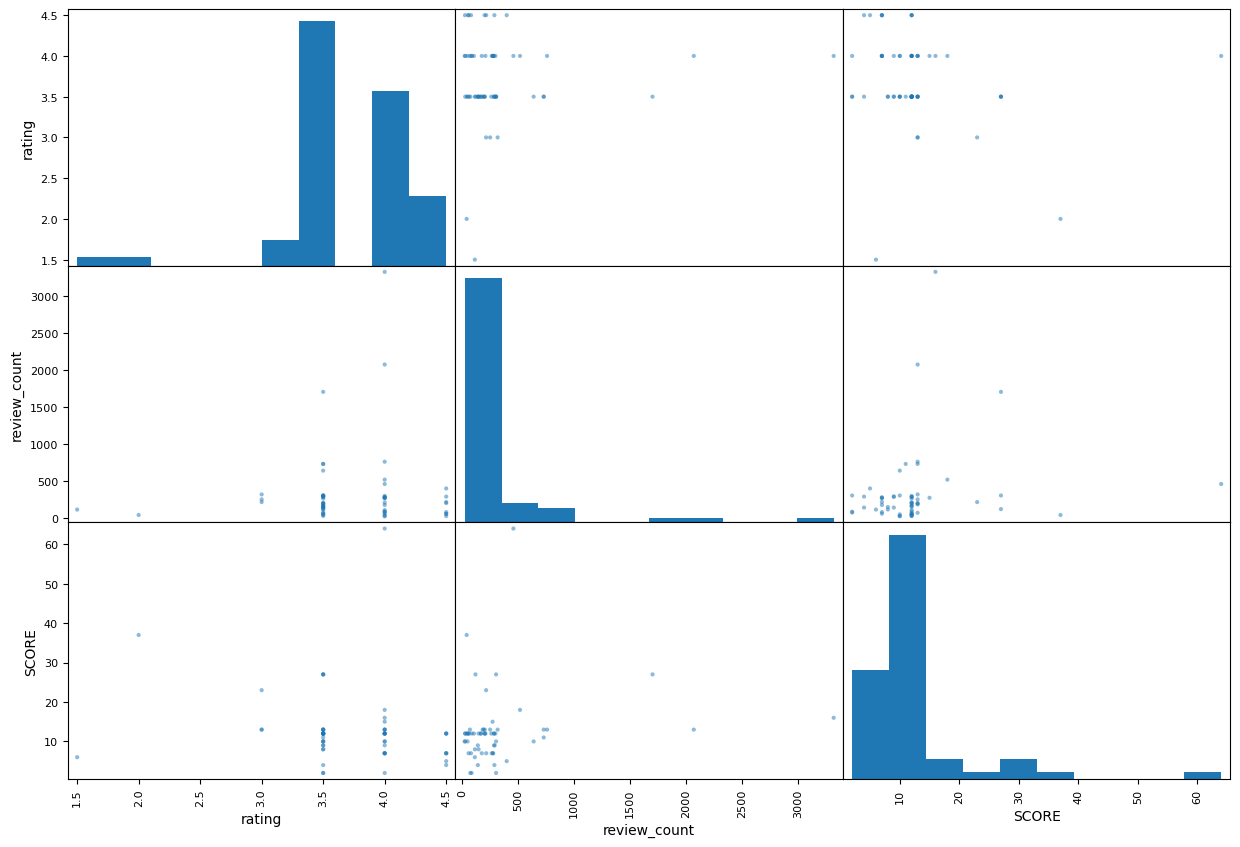

In [46]:
#creates a scatter plot matrix for recent_df
pd.plotting.scatter_matrix(merged_df[['rating','review_count', 'SCORE']], 
                           figsize=(15, 10));

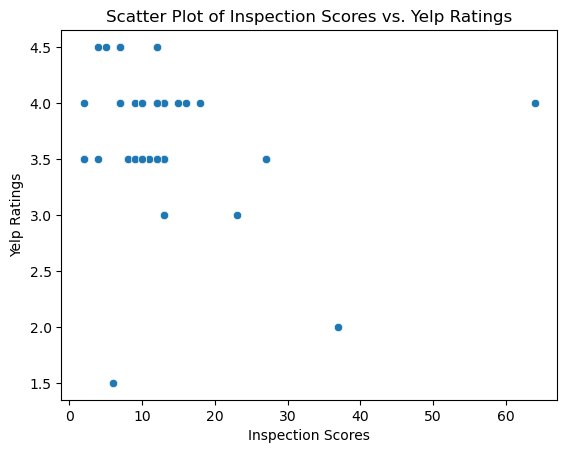

In [31]:
# Visualizing the correlation between Inspection scores and Yelp Ratings
sns.scatterplot(x=merged_df['SCORE'], y=merged_df['rating'])
plt.title('Scatter Plot of Inspection Scores vs. Yelp Ratings')
plt.xlabel('Inspection Scores')
plt.ylabel('Yelp Ratings')
plt.show()

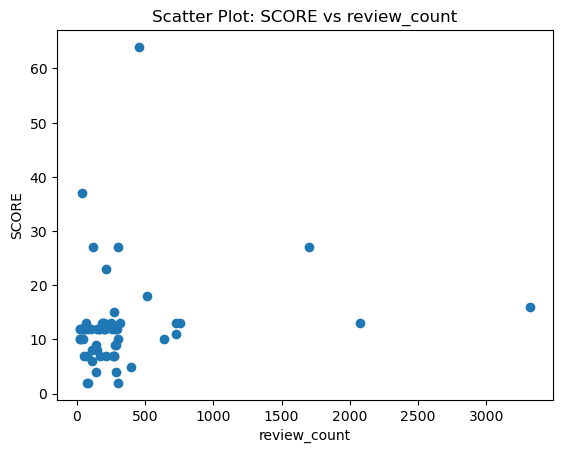

In [32]:
# Scatterplot 
plt.scatter(merged_df['review_count'], merged_df['SCORE'])
plt.xlabel('review_count')
plt.ylabel('SCORE')
plt.title('Scatter Plot: SCORE vs review_count')
plt.show()

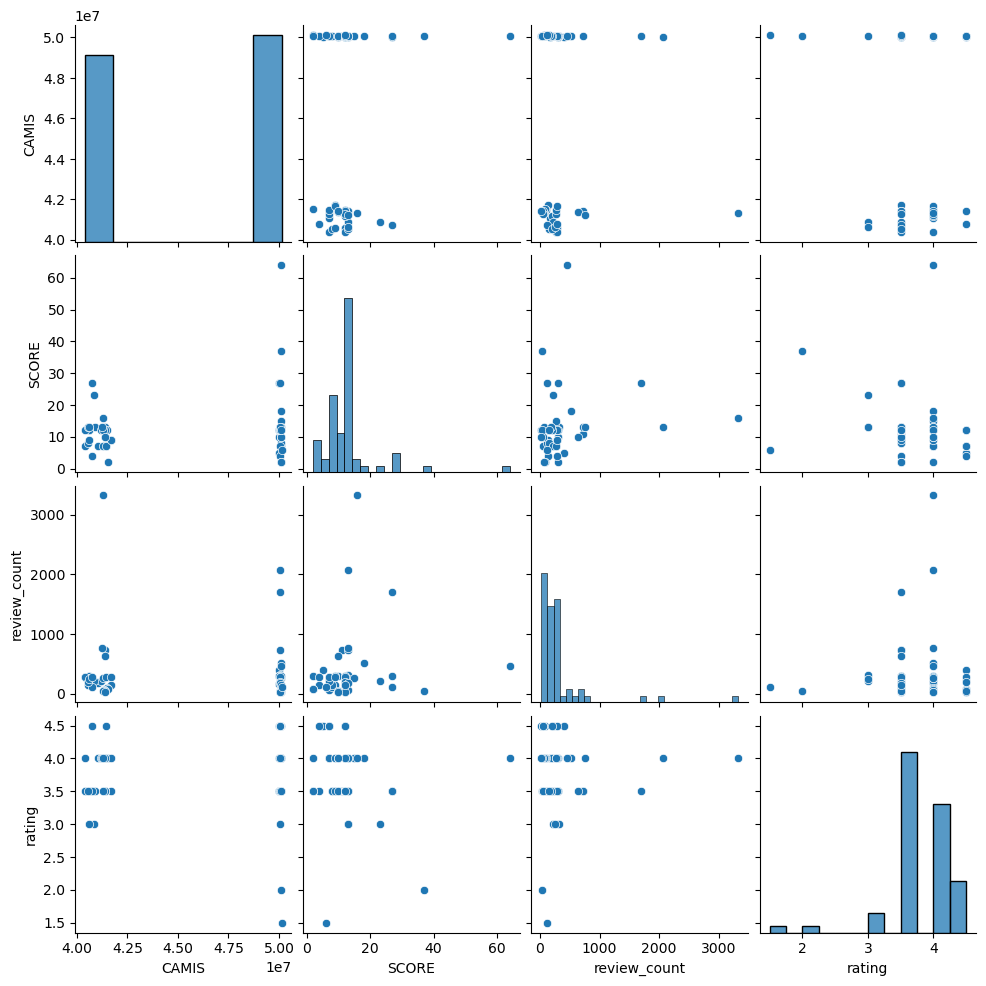

In [33]:
# Pairplot 
sns.pairplot(merged_df)
plt.show()

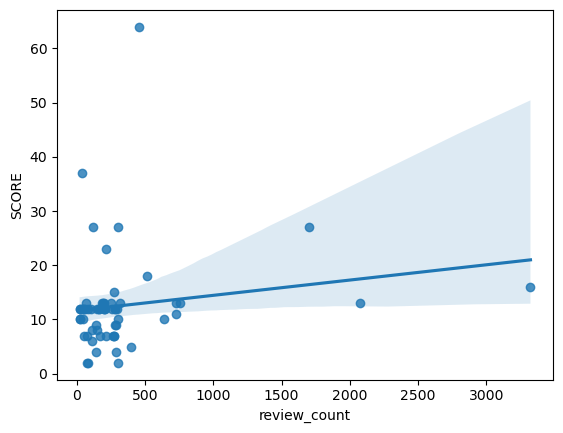

In [34]:
# Reggesion plot
sns.regplot(x='review_count', y='SCORE', data=merged_df)
plt.show()

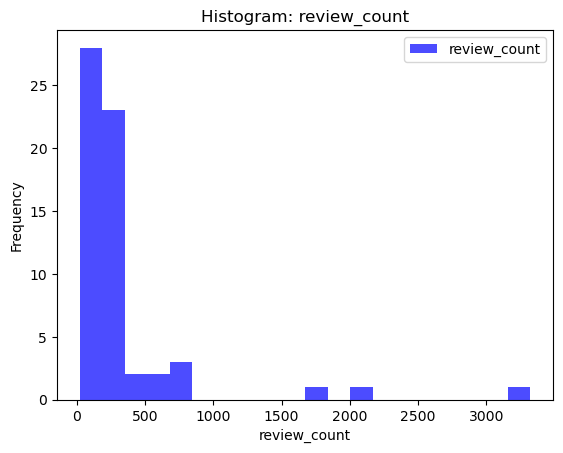

In [35]:
# Histogram 
plt.hist(merged_df['review_count'], bins=20, color='blue', alpha=0.7, label='review_count')
plt.xlabel('review_count')
plt.ylabel('Frequency')
plt.title('Histogram: review_count')
plt.legend()
plt.show()

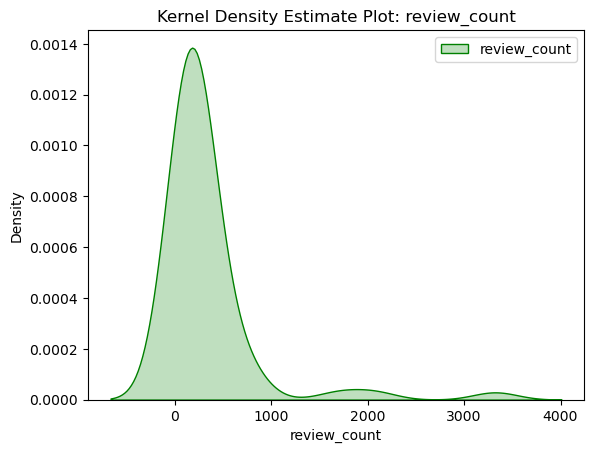

In [36]:
# Kernel Density Estimate Plot
sns.kdeplot(merged_df['review_count'], shade=True, color='green', label='review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.title('Kernel Density Estimate Plot: review_count')
plt.legend()
plt.show()

## **Hypothesis Test 2:Try to find correlation between the inspection grades and the ratings on Yelp data**

## **Consider instead trying to find correlation between amount of reviews and ratings on Yelp data**

In [37]:
# Remove rows with 'N', 'Z', and 'P' in the 'GRADE' column
# These letters signify: N = Not Yet Graded, Z = Grade Pending,
# P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure
#merged_df = merged_df[~merged_df['GRADE'].isin(['N', 'Z', 'P'])]

In [38]:
merged_df['rating'].value_counts()

3.5    28
4.0    20
4.5     8
3.0     3
2.0     1
1.5     1
Name: rating, dtype: int64

In [39]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 266 to 437
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  61 non-null     int64  
 1   DBA                    61 non-null     object 
 2   BORO                   61 non-null     object 
 3   STREET                 61 non-null     object 
 4   CUISINE DESCRIPTION    61 non-null     object 
 5   INSPECTION DATE        61 non-null     object 
 6   ACTION                 61 non-null     object 
 7   VIOLATION CODE         61 non-null     object 
 8   VIOLATION DESCRIPTION  61 non-null     object 
 9   SCORE                  61 non-null     float64
 10  GRADE DATE             61 non-null     object 
 11  INSPECTION TYPE        61 non-null     object 
 12  name                   61 non-null     object 
 13  image_url              61 non-null     object 
 14  review_count           61 non-null     int64  
 15  ratin

In [40]:
print("Number of non-null values in 'rating':", merged_df['rating'].count())

Number of non-null values in 'rating': 61


In [41]:
# review_count_counts = merged_df['review_count'].value_counts().sort_values(ascending=False)
print(merged_df['review_count'])

266     517
16      140
374     303
210      40
516     398
       ... 
19      183
133     147
30       22
471     113
437    3322
Name: review_count, Length: 61, dtype: int64


In [42]:
review_count = merged_df['review_count']
rating = merged_df['rating']

# Calculate IQR
Q1 = review_count.quantile(0.25)
Q3 = review_count.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (review_count < Q1 - 1.5 * IQR) | (review_count > Q3 + 1.5 * IQR)

# Print outliers
print("Outliers:")
print(merged_df[outliers])

Outliers:
        CAMIS                        DBA      BORO            STREET  \
98   50056825                 BEST PIZZA  Brooklyn          AVENUE O   
94   41411423                 BEST PIZZA  Brooklyn  HAVEMEYER STREET   
515  41393052                  IGNAZIO'S  Brooklyn      WATER STREET   
281  50037645                JOE'S PIZZA  Brooklyn    BEDFORD AVENUE   
363  50057010  ARTICHOKE BASILLE'S PIZZA  Brooklyn          4 AVENUE   
84   41250435          VINNIE'S PIZZERIA  Brooklyn    BEDFORD AVENUE   
437  41307383                  ROBERTA'S  Brooklyn     BOGART STREET   

    CUISINE DESCRIPTION INSPECTION DATE  \
98                Pizza      02/28/2022   
94                Pizza      03/16/2023   
515               Pizza      05/08/2023   
281               Pizza      05/08/2023   
363               Pizza      09/06/2023   
84                Pizza      12/06/2023   
437               Pizza      12/28/2022   

                                              ACTION VIOLATION CODE 

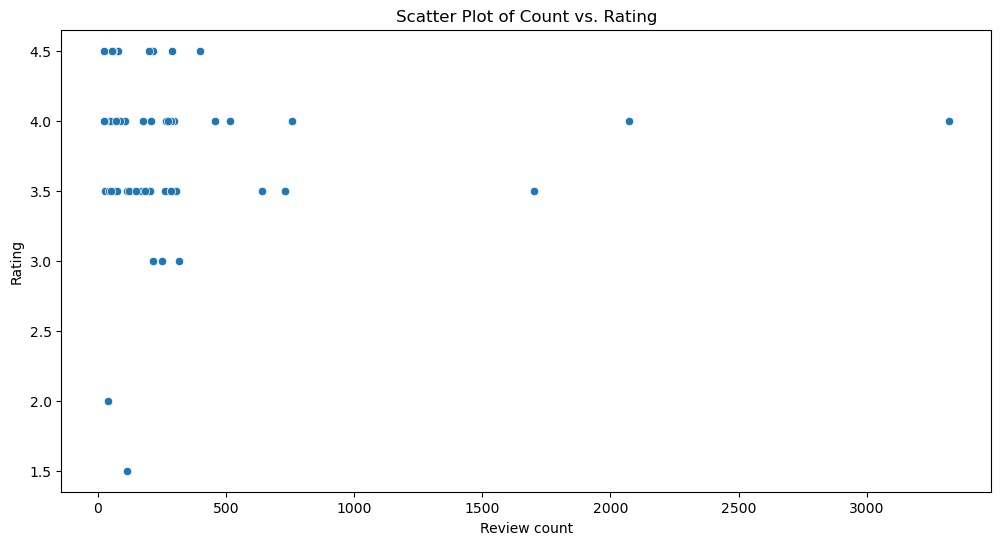

In [43]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='review_count', y='rating', data=merged_df)
plt.title('Scatter Plot of Count vs. Rating')
plt.xlabel('Review count')
plt.ylabel('Rating')
plt.show()

In [44]:
# Drop rows with NaN values if needed
original_length = len(merged_df)
merged_df = merged_df.dropna(subset=['review_count', 'rating'])
new_length = len(merged_df)

print(f'Original length: {original_length}')
print(f'New length after dropping NaN values: {new_length}')


# Convert 'rating' column to numeric
merged_df['rating'] = pd.to_numeric(merged_df['rating'], errors='coerce')

# Replace infinite values with NaN and drop rows with NaN values in the 'rating' column
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=['rating'], inplace=True)

# Perform Pearson correlation test
if len(merged_df['review_count']) < 2 or len(merged_df['rating']) < 2:
    print("Not enough data points to perform the correlation test.")
else:
    # Perform Pearson correlation test
    correlation, p_value = pearsonr(merged_df['review_count'], merged_df['rating'])

    # Print results
    print(f'Correlation: {correlation:.2f}')
    print(f'P-value: {p_value:.4f}')

    # Check for significance based on the p-value
    if p_value < 0.05:
        print('The correlation is statistically significant.')
    else:
        print('There is no significant correlation.')

Original length: 61
New length after dropping NaN values: 61
Correlation: 0.07
P-value: 0.5791
There is no significant correlation.


## **Feature Engineering**

- Find out if there is a significant correlation between certain violations for certain restaurant types of specific areas/boros.

- Most common violations for each restaurant type and each set of chains if applicable for each boro.

- Do corporate restaurants or privately owned places get better scores/grades? What are the most common violations that cost the most points on the inspections.

- Construct predictive models to predict when initial and re-inspections are going to happen

- Construct predictive models to predict which restaurants will pass/fail inspections.

- Find out if there is correlation between a higher score/grade causing a restaurant to recive an overall better score on yelp. Look at the comparison between the results for coporate and privately owned places.